# Hand Gesture Recogntion using CNN (Accuracy 98%)

In [1]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import array_to_img, img_to_array, load_img
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, save_model, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Activation, Dropout 
from keras.utils import plot_model
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.figure_factory as ff




2024-06-27 03:05:01.322991: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-27 03:05:01.323133: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-27 03:05:01.512682: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


<a id="Section 1:read dataset including folders, subfolders, and images :"></a>
# Read Images and Labels in the Dataset  



In [2]:
images=[]
labels=[]

for directory in os.listdir('/kaggle/input/leapgestrecog/leapGestRecog/'):
    for subdir in os.listdir(os.path.join('/kaggle/input/leapgestrecog/leapGestRecog/',directory)):
        for image in os.listdir(os.path.join('/kaggle/input/leapgestrecog/leapGestRecog/',directory, subdir)):
            img_path = os.path.join('/kaggle/input/leapgestrecog/leapGestRecog/', directory, subdir, image)
            images.append(img_path)
            labels.append(subdir)

        

<a id="Section 1:Create DataFrame for Images&Labels:"></a>
# Read Images and Labels in the Dataset  

In [3]:

df = pd.DataFrame({'Image':images,'Label':labels})
df.tail()


,Image,Label
19995,/kaggle/input/leapgestrecog/leapGestRecog/01/0...,03_fist
19996,/kaggle/input/leapgestrecog/leapGestRecog/01/0...,03_fist
19997,/kaggle/input/leapgestrecog/leapGestRecog/01/0...,03_fist
19998,/kaggle/input/leapgestrecog/leapGestRecog/01/0...,03_fist
19999,/kaggle/input/leapgestrecog/leapGestRecog/01/0...,03_fist


<a id="Section 1:Randomly Display some labeled images from the dataset:"></a>
# Randomly Display some labeled images from the dataset 

[[<Axes: > <Axes: > <Axes: > <Axes: > <Axes: >]
 [<Axes: > <Axes: > <Axes: > <Axes: > <Axes: >]]


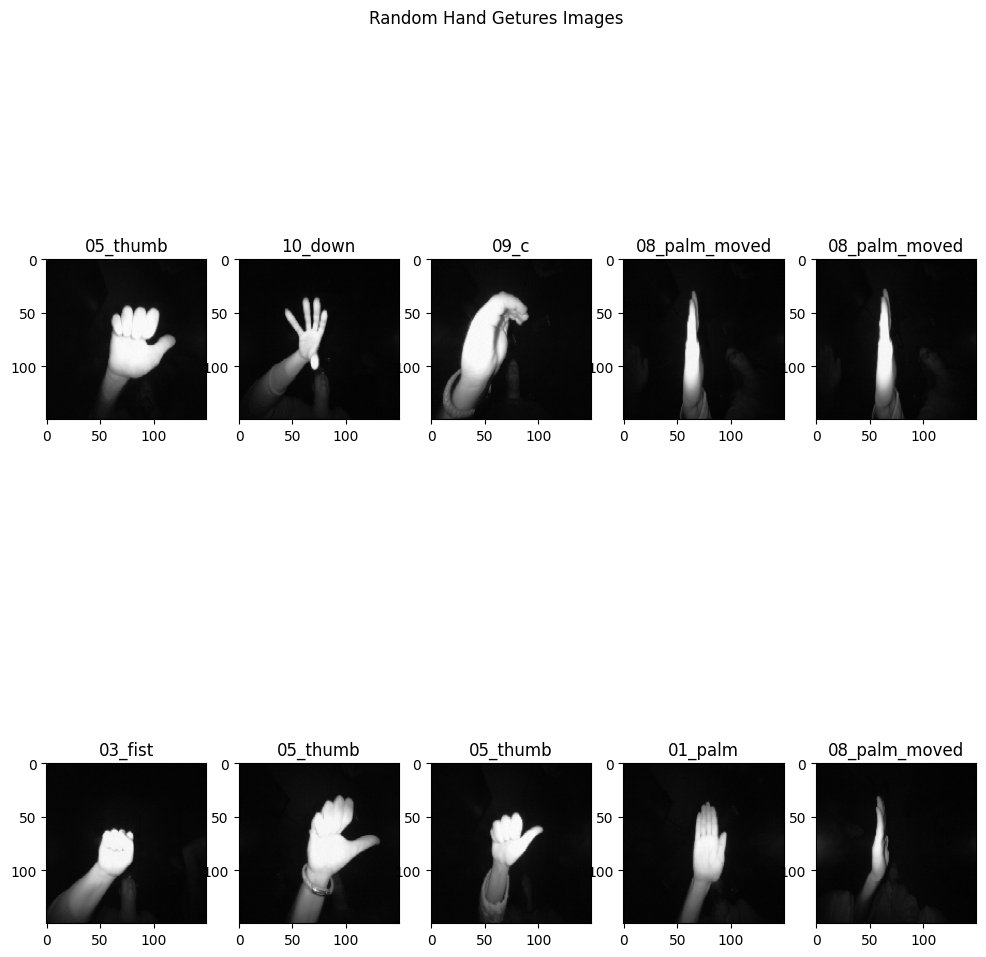

In [4]:

df_img = df['Image']
df_label = df['Label']

nrows=2
ncols = 5
fig,axx = plt.subplots(nrows,ncols, figsize=(12,12))
fig.suptitle("Random Hand Getures Images")
print(axx)

for i in range(nrows):
        for j in range(ncols):
                n = np.random.randint(0,20000)
                img = load_img(df['Image'][n],target_size=(150,150)) 
                img = img_to_array(img) 
                img = np.expand_dims(img,axis=0) 
                img /= 255.0 #scale image values between 0,1
                label = df_label[n]
                
                image = np.squeeze(img)
                axx[i][j].imshow(image)
                axx[i][j].set_title(label)
plt.show()
plt.close()


<a id="Split Dataset into 80% for training 15%,15% for validation and testing:"></a>
# Split Dataset into 70% for training 15%,15% for validation and testing

In [5]:
x_train,x = train_test_split(df, test_size = 0.3)
x_valid,x_test = train_test_split(x,test_size=0.5)
x_train.info()
x_valid.info()
x_test.info()


<class 'pandas.core.frame.DataFrame'>
Index: 14000 entries, 1182 to 403
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Image   14000 non-null  object
 1   Label   14000 non-null  object
dtypes: object(2)
memory usage: 328.1+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 3000 entries, 7483 to 11290
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Image   3000 non-null   object
 1   Label   3000 non-null   object
dtypes: object(2)
memory usage: 70.3+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 3000 entries, 5038 to 12534
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Image   3000 non-null   object
 1   Label   3000 non-null   object
dtypes: object(2)
memory usage: 70.3+ KB


<a id="Data Augmentation:"></a>
# Data Augmentation 

In [6]:

datagen = ImageDataGenerator(
        rotation_range=10, 
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True, 
        brightness_range=[0.2,1.2]) 


train_datagen = ImageDataGenerator(rescale=1.0/255,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True)
validate_datagen = ImageDataGenerator(rescale=1.0/255)

In [7]:
b_size =1
train_generator = train_datagen.flow_from_dataframe(dataframe=x_train,x_col="Image",y_col='Label',class_mode="categorical",target_size=(150,150),batch_size=b_size,seed=2020, shuffle=True)
valid_generator = validate_datagen.flow_from_dataframe(dataframe=x_valid,x_col="Image",y_col='Label',class_mode="categorical",target_size=(150,150),batch_size=b_size,seed=2020, shuffle=False)


Found 14000 validated image filenames belonging to 10 classes.
Found 3000 validated image filenames belonging to 10 classes.


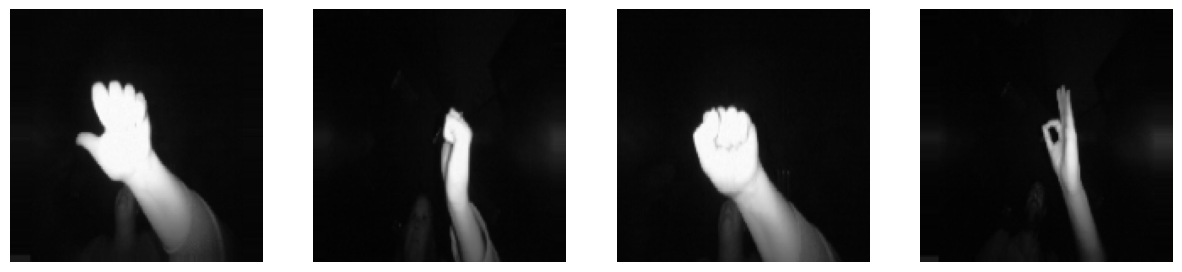

In [8]:

fig,axx = plt.subplots(nrows=1,ncols=4, figsize=(15,15))

for i in range(4):
    image = next(train_generator)[0].astype('float64')
    image = np.squeeze(image)
    axx[i].imshow(image)
    axx[i].axis('off')



<a id="Build Convolutional Neural Network Model (CNN):"></a>
# Build Convolutional Neural Network Model (CNN)

In [9]:

model = Sequential()
model.add(Conv2D(32,(3,3), input_shape=(150,150,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
             optimizer = 'adam',
             metrics=[tf.keras.metrics.CategoricalAccuracy()])
model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 148, 148, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 72, 72, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 34, 34, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,183,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,213,098 (4.63 MB)

 Trainable params: 1,213,098 (4.63 MB)

 Non-trainable params: 0 (0.00 B)

<a id="Visualize Model:"></a>
# Visualize Model

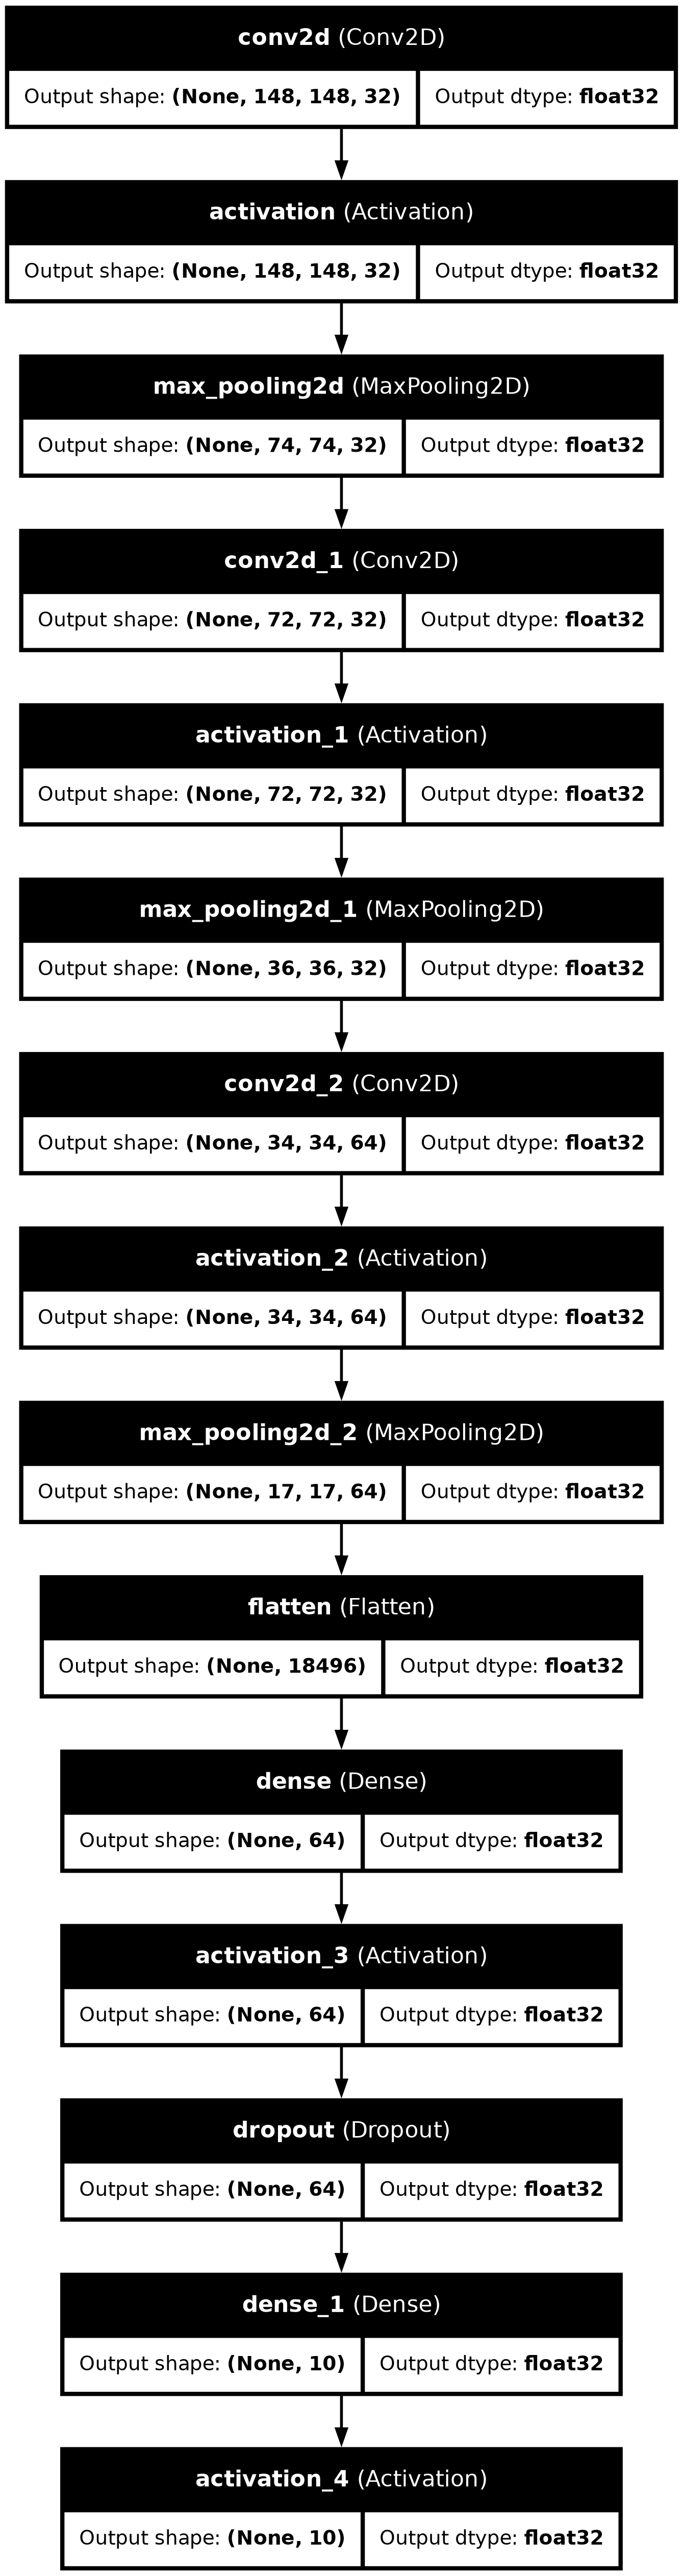

In [10]:

plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True 
)


<a id="Train and save Model:"></a>
# Train and save Model

In [11]:

history = model.fit(train_generator,
                   steps_per_epoch=2000//b_size,
                   epochs = 20,
                   validation_data = valid_generator,
                    validation_steps=800//b_size)
                   
model.save('handG_R.h5')

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 70s 34ms/step - categorical_accuracy: 0.3305 - loss: 1.8621 - val_categorical_accuracy: 0.8863 - val_loss: 0.4896
Epoch 2/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 67s 33ms/step - categorical_accuracy: 0.8085 - loss: 0.5934 - val_categorical_accuracy: 0.9650 - val_loss: 0.1490
Epoch 3/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 67s 33ms/step - categorical_accuracy: 0.8873 - loss: 0.3691 - val_categorical_accuracy: 0.8988 - val_loss: 0.3331
Epoch 4/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 64s 32ms/step - categorical_accuracy: 0.9096 - loss: 0.2891 - val_categorical_accuracy: 0.9833 - val_loss: 0.0744
Epoch 5/20
   5/2000 ━━━━━━━━━━━━━━━━━━━━ 56s 28ms/step - categorical_accuracy: 1.0000 - loss: 0.0502  

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 64s 32ms/step - categorical_accuracy: 0.9353 - loss: 0.1941 - val_categorical_accuracy: 0.9787 - val_loss: 0.0839
Epoch 6/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 64s 32ms/step - categorical_accuracy: 0.9335 - loss: 0.1816 - val_categorical_accuracy: 0.9825 - val_loss: 0.0515
Epoch 7/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 64s 32ms/step - categorical_accuracy: 0.9479 - loss: 0.1763 - val_categorical_accuracy: 0.9812 - val_loss: 0.0814
Epoch 8/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - categorical_accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_categorical_accuracy: 0.9800 - val_loss: 0.0558
Epoch 9/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 65s 32ms/step - categorical_accuracy: 0.9552 - loss: 0.1458 - val_categorical_accuracy: 0.9962 - val_loss: 0.0301
Epoch 10/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 65s 32ms/step - categorical_accuracy: 0.9645 - loss: 0.0991 - val_categorical_accuracy: 0.9925 - val_loss: 0.0226
Epoch 11/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 64s 32ms/step - categoric

In [12]:

history.history

{'categorical_accuracy': [0.5245000123977661,
  0.8349999785423279,
  0.8955000042915344,
  0.9190000295639038,
  0.9330000281333923,
  0.9449999928474426,
  0.9495000243186951,
  0.0,
  0.9524999856948853,
  0.9629999995231628,
  0.9664999842643738,
  0.9695000052452087,
  0.965499997138977,
  0.9645000100135803,
  0.9789999723434448,
  0.0,
  0.972000002861023,
  0.9815000295639038,
  0.9739999771118164,
  0.9779999852180481],
 'loss': [1.4086483716964722,
  0.5130873322486877,
  0.34339508414268494,
  0.23952285945415497,
  0.2123485803604126,
  0.16306032240390778,
  0.15548445284366608,
  0.0,
  0.1499888002872467,
  0.1116064041852951,
  0.10219293087720871,
  0.11624021083116531,
  0.10633033514022827,
  0.10834947228431702,
  0.0879441425204277,
  0.0,
  0.1076117753982544,
  0.0533025898039341,
  0.0830252543091774,
  0.07428337633609772],
 'val_categorical_accuracy': [0.8862500190734863,
  0.9649999737739563,
  0.8987500071525574,
  0.9833333492279053,
  0.9787499904632568,
 

<a id="Visualize training&validation loss:"></a>
# Visualize training&validation loss

In [13]:

fig = go.Figure()
epochs = 20
fig.add_trace(go.Scatter(x=np.arange(0,epochs,1),
y=history.history['loss'],
mode='lines',
name=f'training loss',
marker_size=3,
line_color='blue'))
fig.add_trace(go.Scatter(x=np.arange(0, epochs, 1),
                         y=history.history['val_loss'],
                         mode='lines',
                         name=f'Validation loss',
                         line_color='grey'))
fig.update_layout(
                  title="CNN training loss",
                  xaxis_title="Epochs",
                  yaxis_title=f"CategoricalCrossentropy")
                  
fig.update_layout({'plot_bgcolor': '#f2f8fd' , 
                   'paper_bgcolor': 'white',}, 
                   template='plotly_white')

<a id="Visualize training&validation accuracy:"></a>
# Visualize training&validation accuracy

In [14]:

fig = go.Figure()
epochs = 20
fig.add_trace(go.Scatter(x=np.arange(0,epochs,1),
y=history.history['categorical_accuracy'],
mode='lines',
name=f'training accuracy',
marker_size=3,
line_color='blue'))
fig.add_trace(go.Scatter(x=np.arange(0, epochs, 1),
                         y=history.history['val_categorical_accuracy'],
                         mode='lines',
                         name=f'Validation accuracy',
                         line_color='grey'))
fig.update_layout(
                  title="CNN training accuracy",
                  xaxis_title="Epochs",
                  yaxis_title=f"CategoricalCrossentropy")
                  
fig.update_layout({'plot_bgcolor': '#f2f8fd' , 
                   'paper_bgcolor': 'white',}, 
                   template='plotly_white')

<a id="Train Model:"></a>
# Test Model to new data

In [15]:
x_test.info()
x_test.tail(20)
samples= x_test.sample(n=5)


<class 'pandas.core.frame.DataFrame'>
Index: 3000 entries, 5038 to 12534
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Image   3000 non-null   object
 1   Label   3000 non-null   object
dtypes: object(2)
memory usage: 70.3+ KB


In [16]:
model = load_model('./handG_R.h5',compile=True)
